In [168]:
# ML methods: linear regression, logistic regression, geographical weighted regression, random forest, support vector machine, neural network

# Load the data

In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import pyproj
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import pyproj
utm = pyproj.CRS('EPSG:32618')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'
# import chardet
random.seed(42)
np.random.seed(42)
df_input = pd.read_parquet(P.data+"/df_input_merged.parquet")


df_input['POP'] = df_input['e_totpop']
df_input['CASE_0'] = df_input['Cases_wave0']
df_input['CASE_1'] = df_input['Cases_wave1']
df_input['CASE_2'] = df_input['Cases_wave2']
df_input['CASE_3'] = df_input['Cases_wave3']

df_input['RATIO_0'] = df_input['Positive_wave0']*100
df_input['RATIO_1'] = df_input['Positive_wave1']*100
df_input['RATIO_2'] = df_input['Positive_wave2']*100
df_input['RATIO_3'] = df_input['Positive_wave3']*100

df_input['VAC_0'] = df_input['Completed_wave0']
df_input['VAC_1'] = df_input['Completed_wave1']
df_input['VAC_2'] = df_input['Completed_wave2']
df_input['VAC_3'] = df_input['Completed_wave3']

df_input['POP_DENSITY'] = df_input['POP']/df_input['area_sqmi']
# df_input['POP_DENSITY_LOG'] = np.log10(df_input['POP_DENSITY']+1)
df_input['AGE_MINOR'] = df_input['ep_age17']
df_input['AGE_SENIOR'] = df_input['ep_age65']
df_input['RACE_HISP'] = df_input['ep_hisp']
df_input['RACE_AFAM'] = df_input['ep_afam']
df_input['RACE_ASIAN'] = df_input['ep_asian']
df_input['NO_HSDP'] = df_input['ep_nohsdp']
df_input['NO_EMPLOY'] = df_input['ep_unemp']
df_input.loc[df_input['NO_EMPLOY']<0,'NO_EMPLOY'] = np.nan
df_input['POP_POOR'] = df_input['ep_pov150']
df_input['NO_VEH'] = df_input['ep_noveh']
df_input.loc[df_input['NO_VEH']<0,'NO_VEH'] = np.nan
df_input['NO_INSUR'] = df_input['ep_uninsur']
df_input.loc[df_input['NO_INSUR']<0,'NO_INSUR'] = np.nan
df_input['POP_DISABLE'] = df_input['ep_disabl']
df_input.loc[df_input['POP_DISABLE']<0,'POP_DISABLE'] = np.nan

df_input['DIST_IDA'] = df_input['dist_to_Ida']
df_input['DIST_COAST'] = df_input['dist_to_south_bound']
df_input['DIST_NICHOLAS'] = df_input['dist_to_Nicholas']

df_input['EVAC_0'] = df_input['disp_ratio_wave0']
df_input['EVAC_1'] = df_input['disp_ratio_wave1']
df_input['EVAC_2'] = df_input['disp_ratio_wave2']
df_input['EVAC_3'] = df_input['disp_ratio_wave3']

df_input['RETURN_0'] = df_input['return_ratio_wave0_7days']
df_input['RETURN_1'] = df_input['return_ratio_wave1_7days']
df_input['RETURN_2'] = df_input['return_ratio_wave2_7days']
df_input['RETURN_3'] = df_input['return_ratio_wave3_7days']

df_input['DIST_0'] = df_input['dist_wave0'].clip(lower = 1)
df_input['DIST_1'] = df_input['dist_wave1'].clip(lower = 1)
df_input['DIST_2'] = df_input['dist_wave2'].clip(lower = 1)
df_input['DIST_3'] = df_input['dist_wave3'].clip(lower = 1)

df_input['DURATION_0'] = df_input['duration_wave0']
df_input['DURATION_1'] = df_input['duration_wave1']
df_input['DURATION_2'] = df_input['duration_wave2']
df_input['DURATION_3'] = df_input['duration_wave3']

df_input['URBAN'] = df_input['urban'].astype(int)

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')
merged_tract = merged_tract[['id','geometry']].to_crs(CRS_M)

df_input = pd.merge(merged_tract, df_input, on = 'id').set_geometry('geometry')

df_input.dropna(inplace= True)


normalize_factors =  ['DIST_IDA', 'DIST_COAST',  \
                      # 'POP_DENSITY',\
                    #   'DIST_NICHOLAS', \
            'CASE_0', 'VAC_0', \
              # 'RATIO_0',\
           'CASE_1', 'VAC_1', \
          #  'RATIO_1',\
           'CASE_2', 'VAC_2', \
          #  'RATIO_2',\
           'CASE_3', 'VAC_3', \
          #  'RATIO_3',\
          #  'POP_DENSITY', 'POP',\
           'AGE_MINOR', 'AGE_SENIOR', \
           'RACE_HISP', 'RACE_AFAM', 'RACE_ASIAN', \
           'NO_HSDP', 'NO_EMPLOY',  \
            'NO_VEH', \
            'NO_INSUR', 'POP_DISABLE', 'POP_POOR', \
          ]
factors = normalize_factors + ['URBAN']
targets = ['EVAC_0', 'RETURN_0', 'DIST_0', 'DURATION_0',\
          'EVAC_1', 'RETURN_1', 'DIST_1', 'DURATION_1',\
          'EVAC_2', 'RETURN_2', 'DIST_2', 'DURATION_2',\
          'EVAC_3', 'RETURN_3', 'DIST_3', 'DURATION_3']


for factor_name in factors:
    print(factor_name.replace('_',r'\_')+' & - & '+f'{round(np.nanmean(df_input[factor_name]),2)} ({round(np.nanstd(df_input[factor_name]),2)})' +\
          f' & {round(np.nanmin(df_input[factor_name]),2)} & {round(np.nanmax(df_input[factor_name]),2)} & - & -')

for factor_name in targets:
    print(factor_name.replace('_',r'\_')+' & - & '+f'{round(np.nanmean(df_input[factor_name]),2)} ({round(np.nanstd(df_input[factor_name]),2)})' +\

          f' & {round(np.nanmin(df_input[factor_name]),2)} & {round(np.nanmax(df_input[factor_name]),2)} & - & -')

DIST\_IDA & - & 31.24 (25.54) & 0.0 & 94.26 & - & -
DIST\_COAST & - & 45.37 (24.4) & 0.0 & 88.54 & - & -
CASE\_0 & - & 0.5 (0.14) & 0.25 & 0.95 & - & -
VAC\_0 & - & 44.74 (6.79) & 34.0 & 58.0 & - & -
CASE\_1 & - & 0.68 (0.19) & 0.34 & 1.33 & - & -
VAC\_1 & - & 42.96 (7.05) & 32.0 & 57.0 & - & -
CASE\_2 & - & 0.51 (0.15) & 0.23 & 1.05 & - & -
VAC\_2 & - & 44.07 (7.03) & 33.0 & 58.0 & - & -
CASE\_3 & - & 0.35 (0.11) & 0.15 & 0.76 & - & -
VAC\_3 & - & 44.74 (6.79) & 34.0 & 58.0 & - & -
AGE\_MINOR & - & 23.75 (4.66) & 10.6 & 37.43 & - & -
AGE\_SENIOR & - & 14.91 (5.08) & 2.84 & 44.09 & - & -
RACE\_HISP & - & 5.47 (4.74) & 0.0 & 33.41 & - & -
RACE\_AFAM & - & 28.03 (23.21) & 0.0 & 98.33 & - & -
RACE\_ASIAN & - & 1.72 (2.73) & 0.0 & 15.82 & - & -
NO\_HSDP & - & 9.41 (4.85) & 0.61 & 33.1 & - & -
NO\_EMPLOY & - & 3.97 (2.56) & 0.0 & 18.59 & - & -
NO\_VEH & - & 5.58 (4.61) & 0.0 & 21.14 & - & -
NO\_INSUR & - & 8.24 (3.49) & 0.43 & 20.3 & - & -
POP\_DISABLE & - & 15.07 (5.3) & 2.6 & 39.67 & - & 

In [15]:
# # Pairplot 
# import seaborn as sns

# sns.pairplot(df_input, y_vars = targets, x_vars = normalize_factors[10:], kind = 'reg', diag_kind = None)

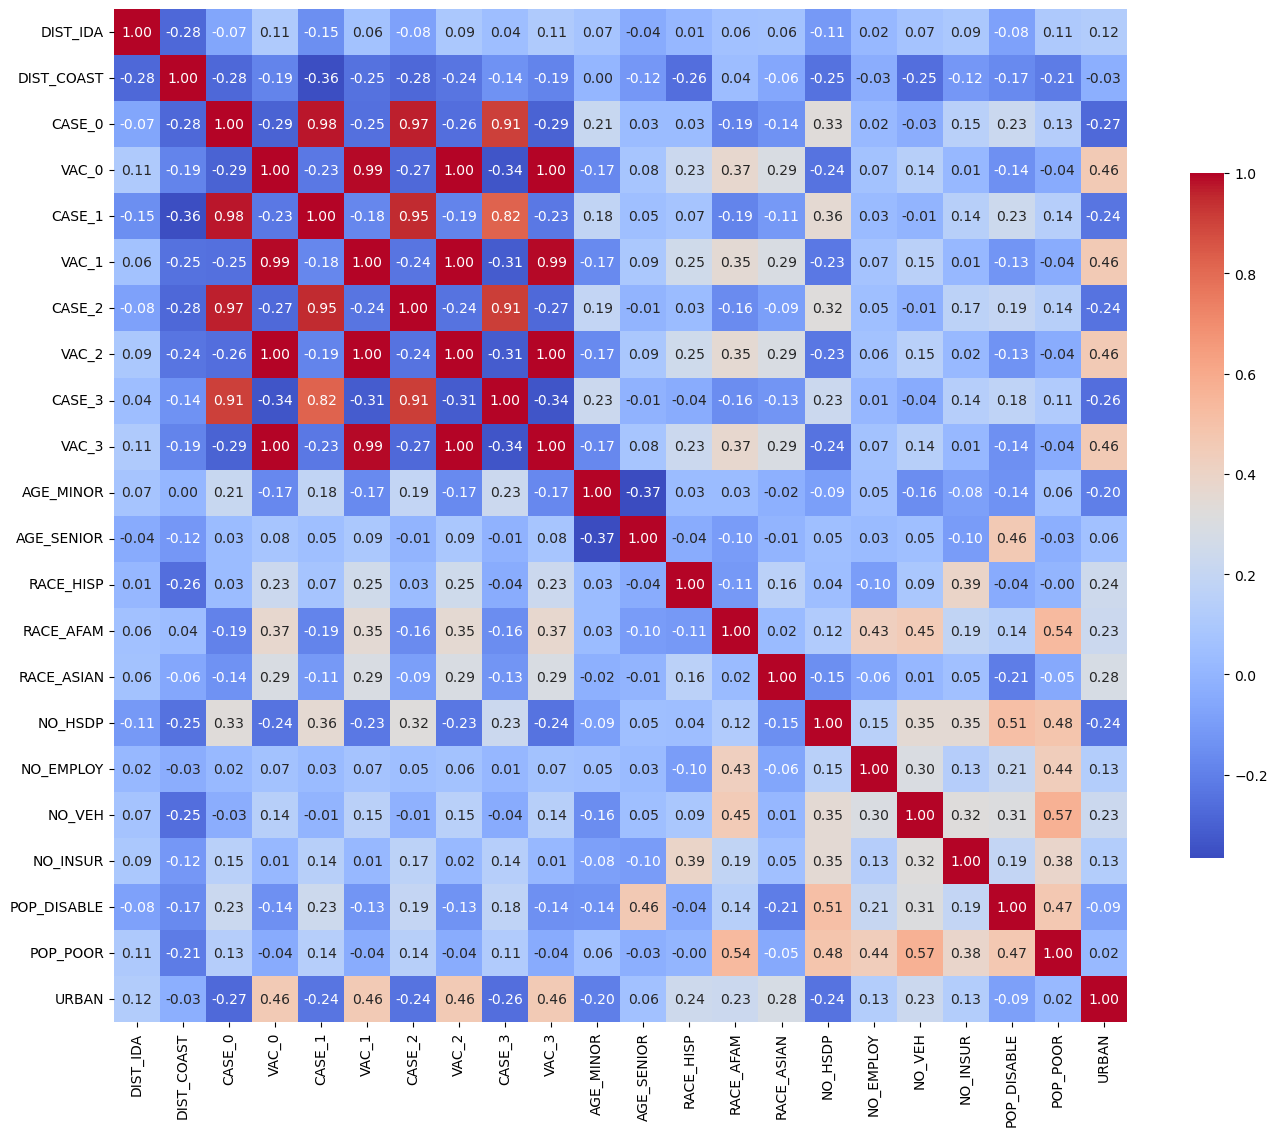

In [16]:
factors = factors
corr = df_input[factors].corr() # factors + targets

# rename the correlation matrix
corr.index = [f for f in factors]
corr.columns = [f for f in factors]

# Plot the heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True,  cbar_kws={"shrink": .5})
# plt.title('Correlation matrix of factors')
plt.tight_layout()

plt.savefig('../figs/corr_matrix.png', dpi=300)
plt.savefig('../figs/corr_matrix.pdf', dpi=300)


In [17]:
xmin, ymin, xmax, ymax = df_input.to_crs(CRS_M).total_bounds

Question: Nonlinear model could be wrong, please check => your data preprocessing could be wrong.

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

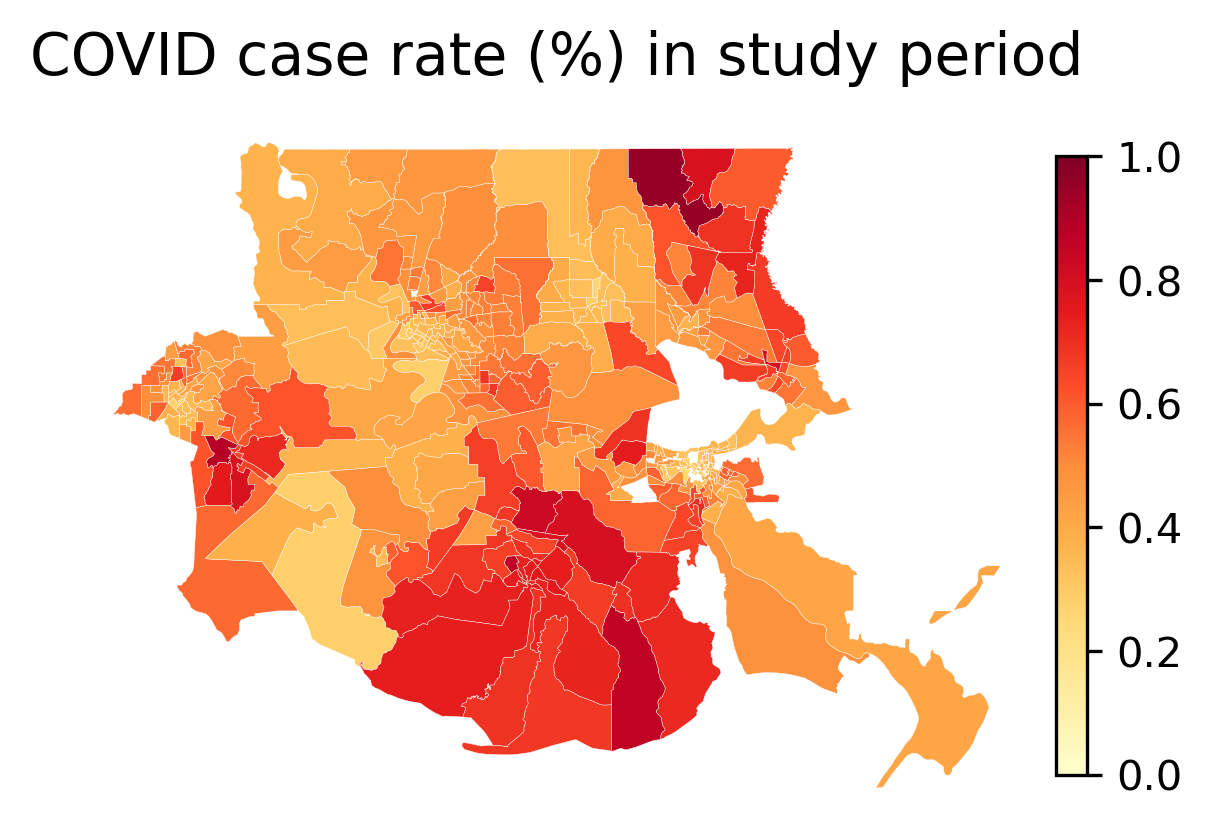

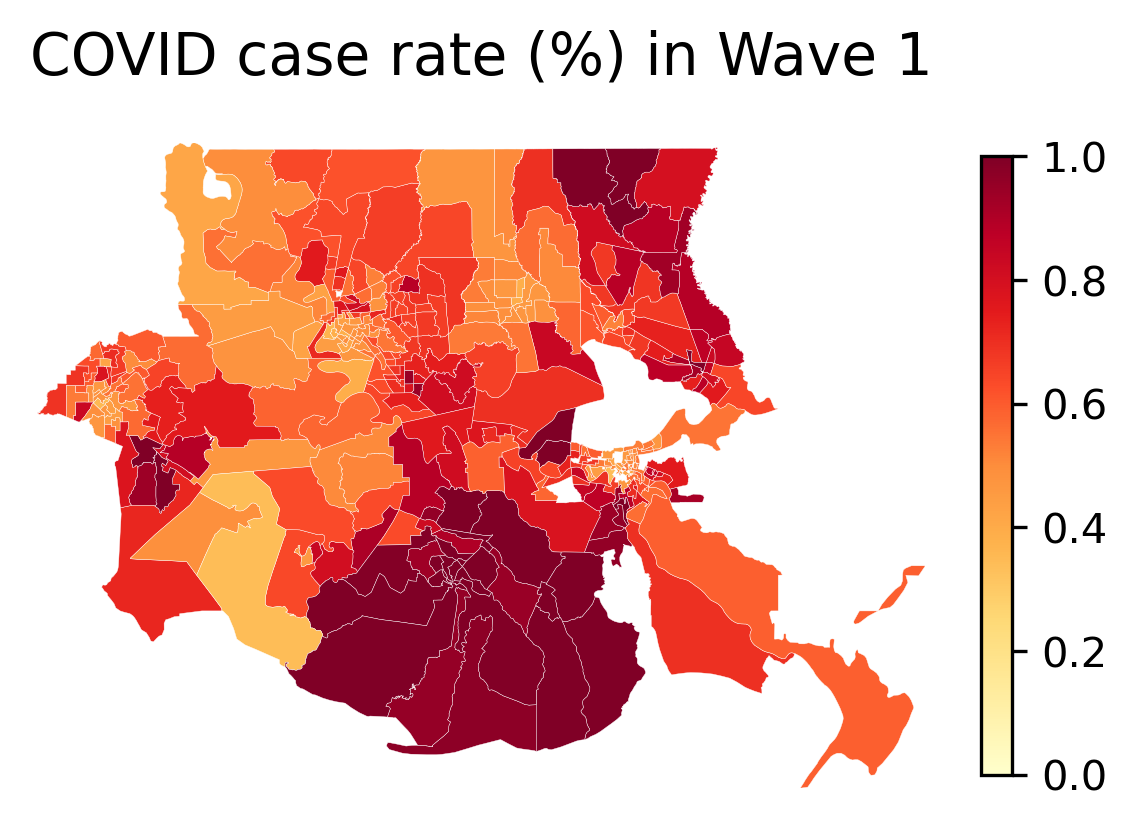

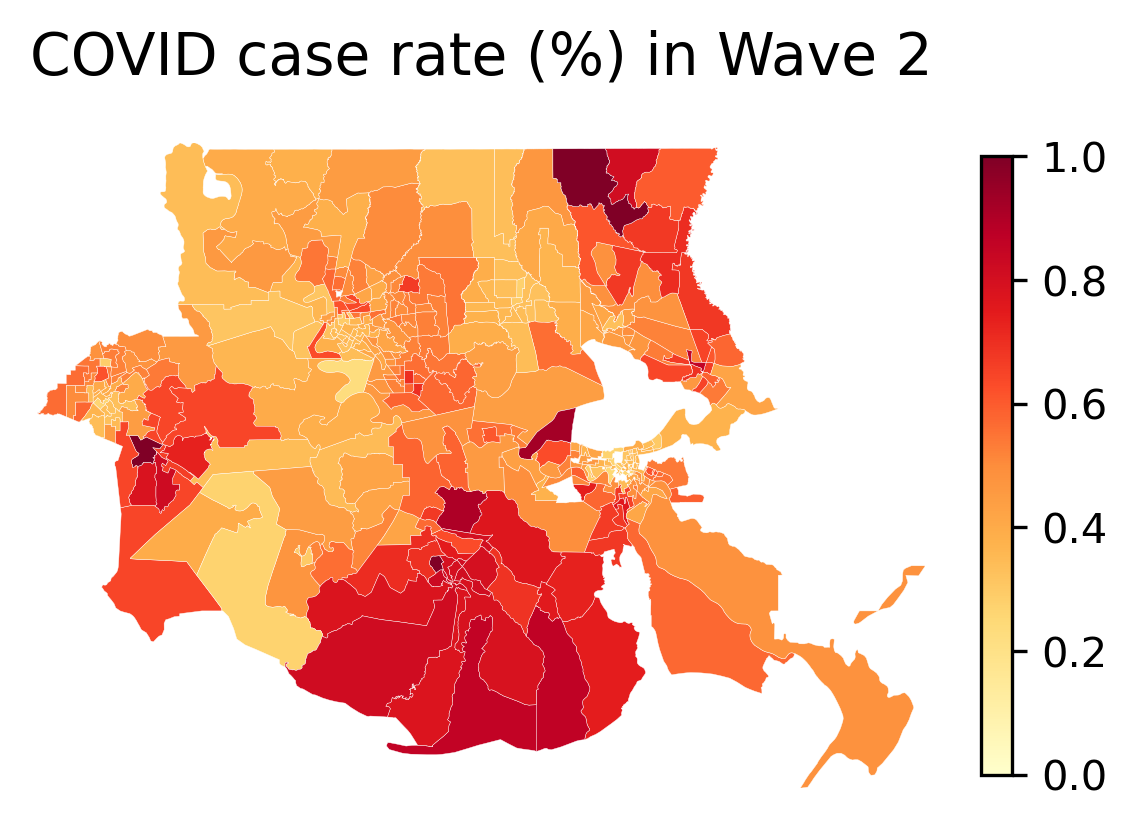

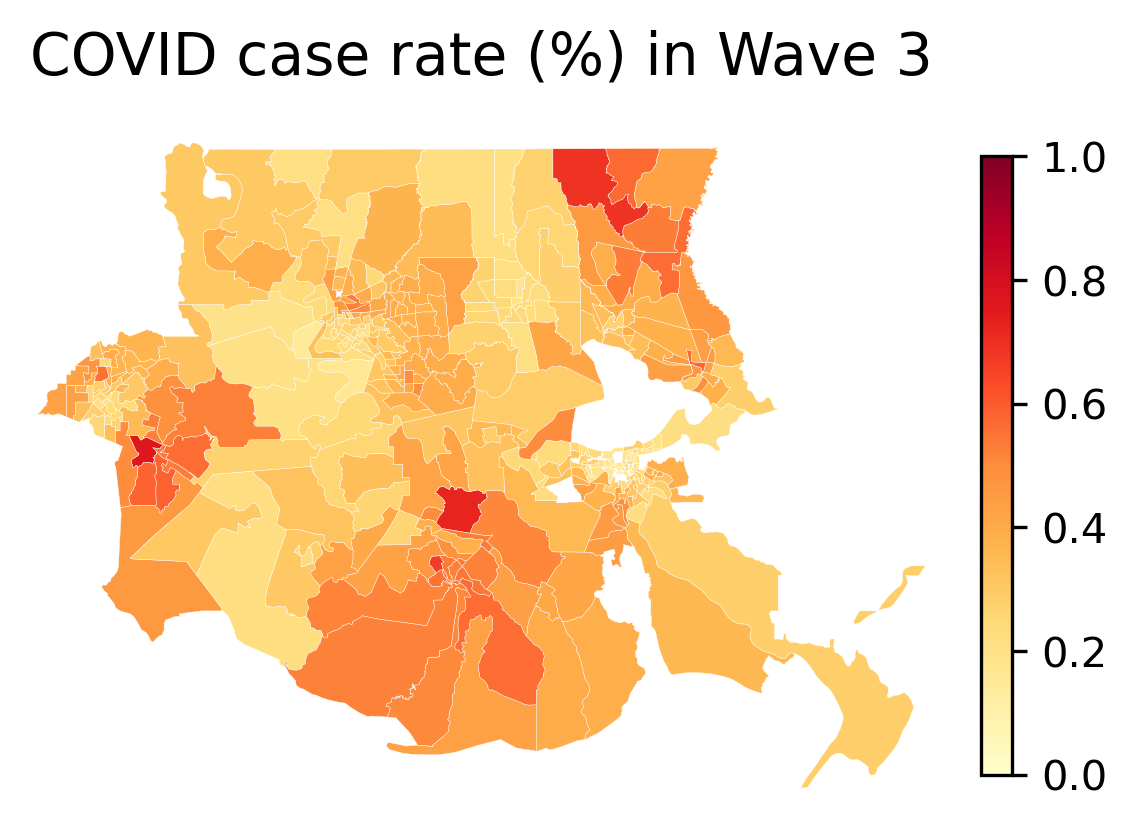

In [18]:
# COVID cases and vaccination rate
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} evacuation cycle duration')
    if i <= 1:
        df_input.to_crs(CRS_M).plot(
        ax=ax, column=f'CASE_{i}', cmap='YlOrRd', legend=True, 
        vmin=0, vmax=1, linewidth=0.1, edgecolor='white',
        legend_kwds={'shrink':0.8})#, 'label':'Evacuation cycle duration (day)'})
    else:
        df_input.to_crs(CRS_M).plot(
        ax=ax, column=f'CASE_{i}', cmap='YlOrRd', legend=True, 
        vmin=0, vmax=1, linewidth=0.1, edgecolor='white',
        legend_kwds={'shrink':0.8})#, 'label':'Evacuation cycle duration (day)'})
    
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    if i == 0:
        plt.title(f'COVID case rate (%) in study period', fontsize=14)
    else:
        plt.title(f'COVID case rate (%) in Wave {i}', fontsize=14)

    # ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Avg. evacuation\ncycle duration: {merged_home.loc[merged_home[f'disp_wave{i}']]['duration'].mean()/2:.2f} days") # show evacuation rate in the plot
    plt.tight_layout()

    plt.savefig(f'../figs/wave{i}_case.pdf')
    plt.savefig(f'../figs/wave{i}_case.png', dpi=300)

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

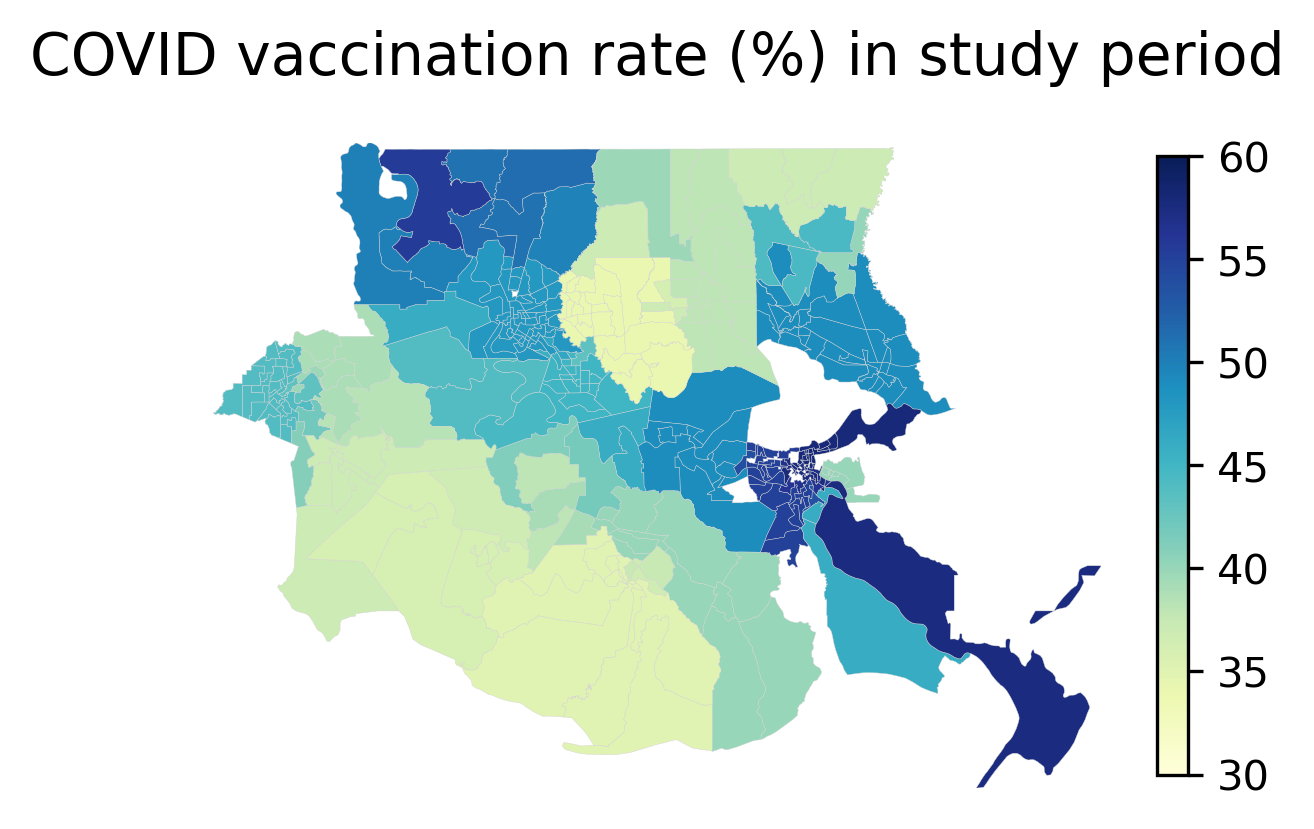

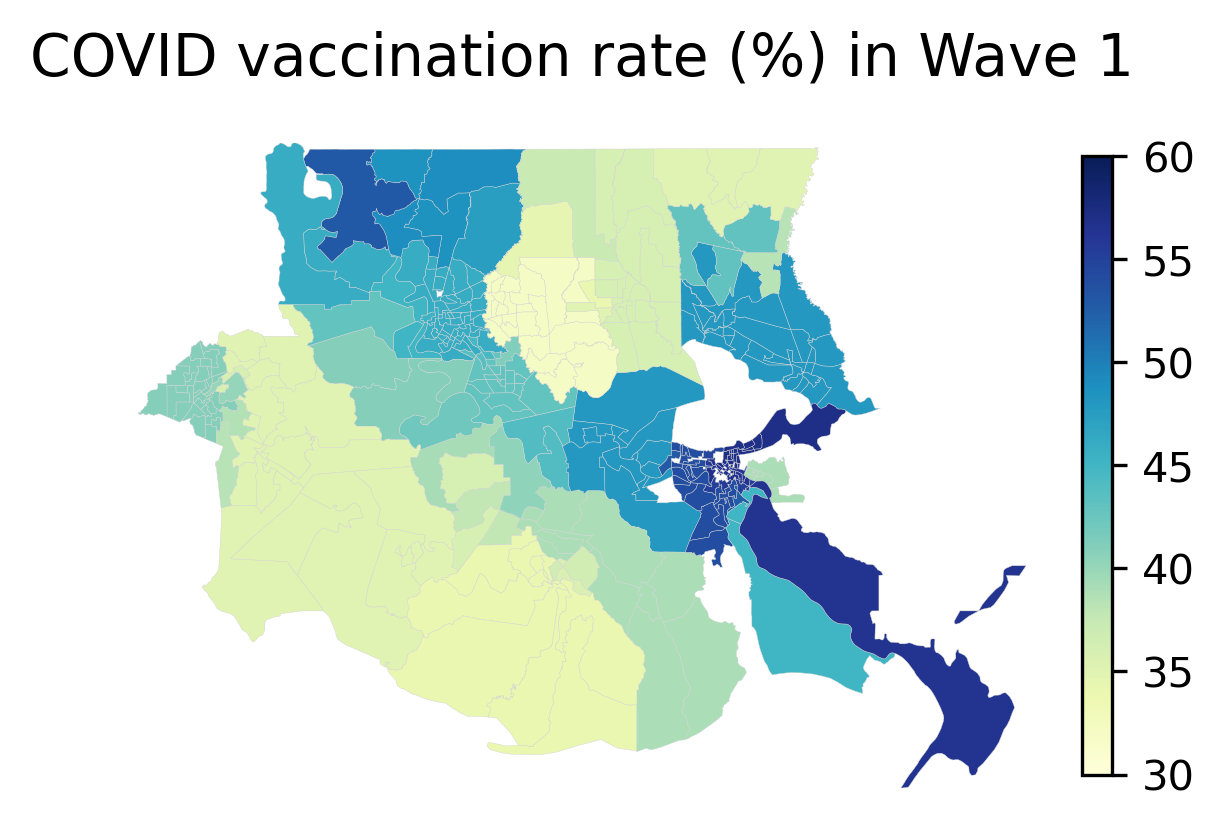

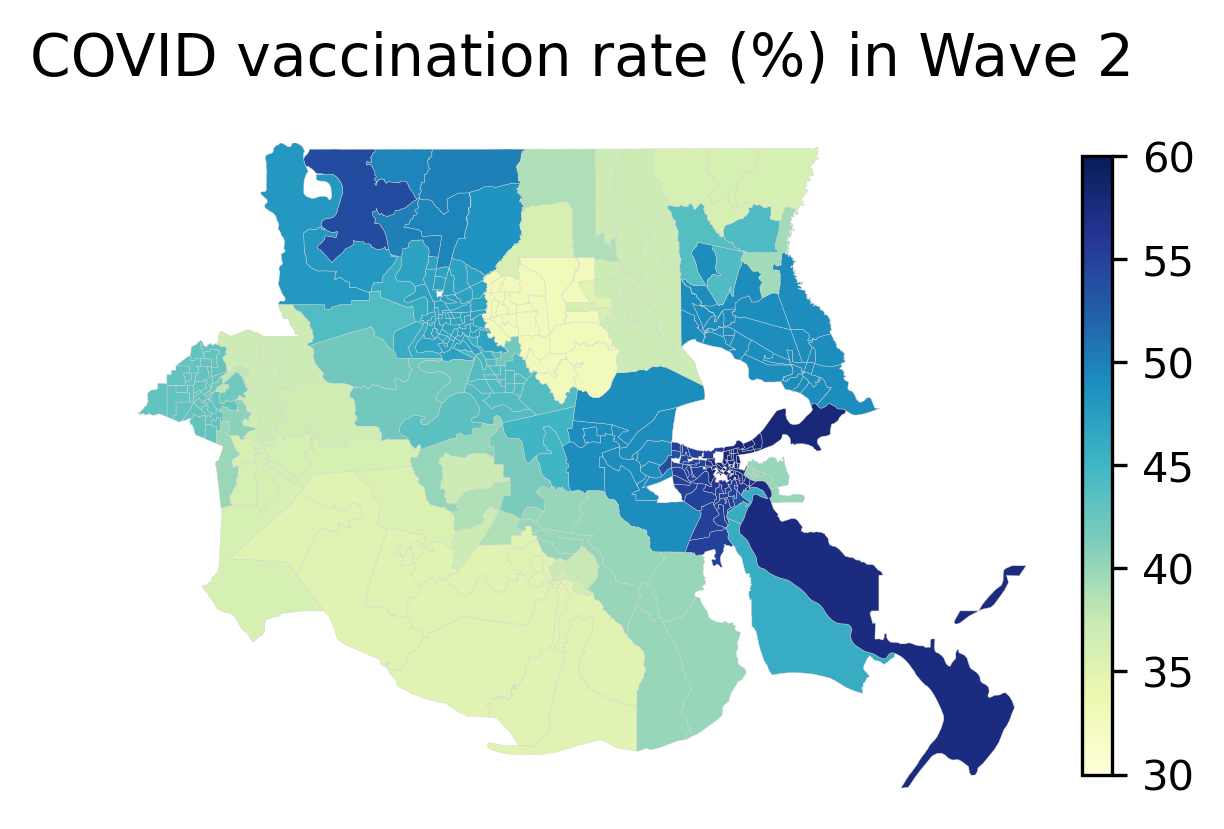

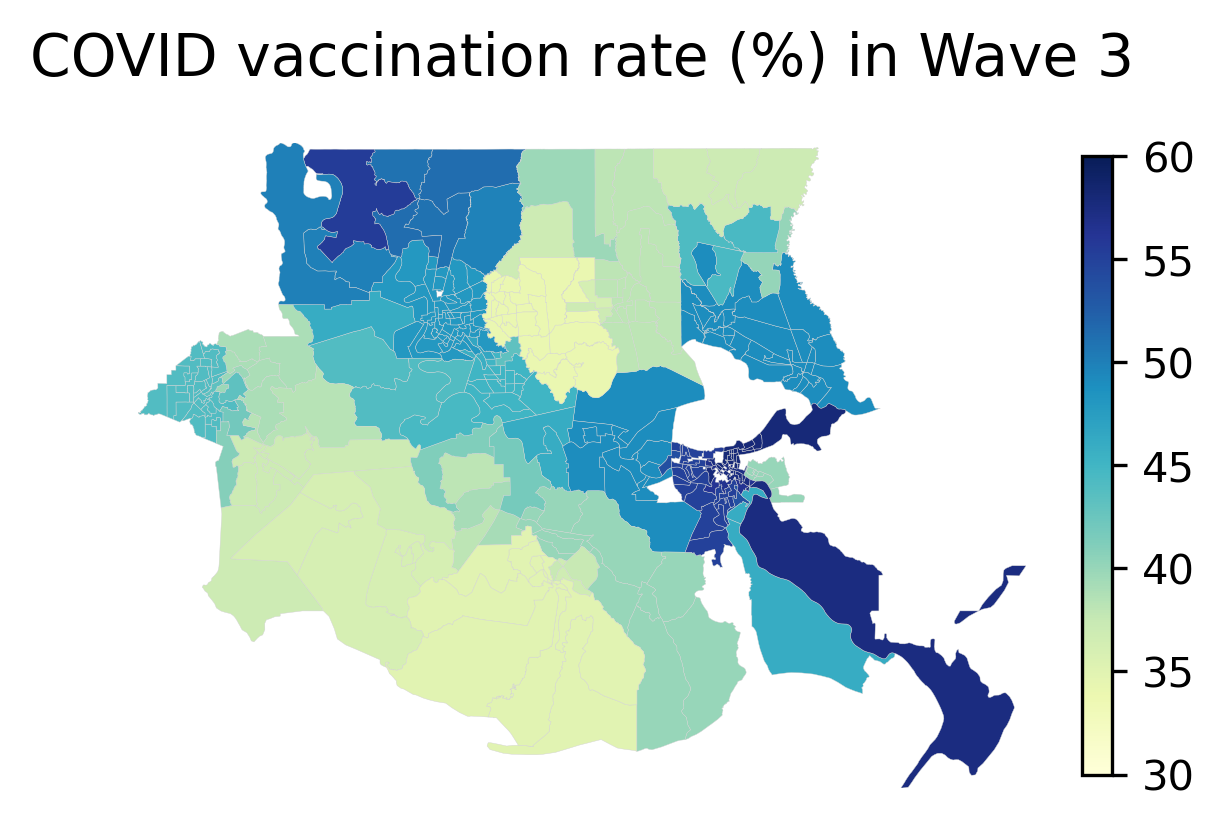

In [19]:
# COVID cases and vaccination rate
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} evacuation cycle duration')
    df_input.to_crs(CRS_M).plot(
      ax=ax, column=f'VAC_{i}', cmap='YlGnBu', legend=True, 
      vmin=30, vmax=60, linewidth=0.1, edgecolor='lightgrey',
      legend_kwds={'shrink':0.8})#, 'label':'Evacuation cycle duration (day)'})
    
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    if i == 0:
        plt.title(f'COVID vaccination rate (%) in study period', fontsize=14)
    else:
        plt.title(f'COVID vaccination rate (%) in Wave {i}', fontsize=14)

    # ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Avg. evacuation\ncycle duration: {merged_home.loc[merged_home[f'disp_wave{i}']]['duration'].mean()/2:.2f} days") # show evacuation rate in the plot
    plt.tight_layout()

    plt.savefig(f'../figs/wave{i}_vac.pdf')
    plt.savefig(f'../figs/wave{i}_vac.png', dpi=300)

In [20]:
np.random.seed(42)
cv_ind = np.random.permutation(np.arange(len(df_input)))
cv_ind = np.array_split(cv_ind, 5)

In [21]:
# get the train, test data
fold = 0
train_ind, test_ind = train_test_split(np.arange(len(df_input)), test_size=0.2, random_state=42)
train_ind, test_ind = np.concatenate([cv_ind[i] for i in range(5) if i != fold]), cv_ind[fold]
df_train = df_input.iloc[train_ind].reset_index(drop=True)
df_test = df_input.iloc[test_ind].reset_index(drop=True)
# data normalization except for binary variables
scaler = StandardScaler()
scaler.fit(df_train[normalize_factors])
df_train[normalize_factors] = scaler.transform(df_train[normalize_factors])
df_test[normalize_factors] = scaler.transform(df_test[normalize_factors])

# VAC to a binary variable
# CASE to 0 when dist exceed 50 miles
for i in range(4):
    thres = 0
    df_train[f'VAC_star_{i}'] = df_train[f'VAC_{i}'].apply(lambda x: x if x<=thres else 0)
    df_test[f'VAC_star_{i}'] = df_test[f'VAC_{i}'].apply(lambda x: x if x<=thres else 0)

    df_train[f'VAC_star2_{i}'] = df_train[f'VAC_{i}'].apply(lambda x: x if x>thres else 0)
    df_test[f'VAC_star2_{i}'] = df_test[f'VAC_{i}'].apply(lambda x: x if x>thres else 0)
    
    thres = 50
    df_train[f'CASE_star_{i}'] = df_train.apply(lambda row: row[f'CASE_{i}'] if row['dist_to_Ida']<=thres else 0, axis= 1)
    df_test[f'CASE_star_{i}'] = df_test.apply(lambda row: row[f'CASE_{i}'] if row['dist_to_Ida']<=thres else 0, axis= 1)

    df_train[f'CASE_star2_{i}'] = df_train.apply(lambda row: row[f'CASE_{i}'] if row['dist_to_Ida']>thres else 0, axis= 1)
    df_test[f'CASE_star2_{i}'] = df_test.apply(lambda row: row[f'CASE_{i}'] if row['dist_to_Ida']>thres else 0, axis= 1)

scaler_y = {}      
for target in targets:
    scaler_y[target] = StandardScaler()
    scaler_y[target].fit(df_train[[target]].values)

coord = np.array([(i.xy[0][0],i.xy[1][0]) for i in df_input.to_crs(utm).centroid.values.tolist()])

In [22]:
targets = ['EVAC_0', 'RETURN_0', 'DIST_0', 'DURATION_0',\
          'EVAC_1','EVAC_2', 'EVAC_3', 'RETURN_1', 'RETURN_2',\
            'RETURN_3', 'DIST_1', 'DIST_2','DIST_3', \
            'DURATION_1','DURATION_2', 'DURATION_3']


In [23]:
def get_X_names(wave = 0, covid = False):
      X_names = ['DIST_IDA',\
                  'DIST_COAST', \
                   'URBAN',\
                   'AGE_MINOR', \
                   'AGE_SENIOR', \
                   'RACE_HISP', \
                   'RACE_AFAM', \
                   'RACE_ASIAN',\
                   'NO_EMPLOY', \
                   'NO_INSUR',\
                   'NO_HSDP', \
                   'NO_VEH', \
                   'POP_DISABLE', \
                        'POP_POOR']

      if covid:
            X_names += [f'CASE_{wave}', f'VAC_{wave}']
      return X_names

In [24]:
from scipy.stats import t
# linear regression print out the R^2 and coefficient (+ the significance) of different variables
res = {}
for w in range(1, 4):
      y_names = [f'EVAC_{w}', f'RETURN_{w}', f'DIST_{w}', f'DURATION_{w}']
      for k in range(4):
            X_names = get_X_names(wave = w, covid = True)
            X = df_input[X_names].values
            y = df_input[y_names[k]].values
            model = LinearRegression()
            model.fit(X, y)
            # R^2, coefficients+ intercept + p-value
            y_pred = model.predict(X)
            residuals = y - y_pred
            n = len(y)  # number of samples
            p = X.shape[1]  # number of features
            df_resid = n - p - 1  # degrees of freedom for residuals
            # Calculate standard errors of coefficients
            mse = np.sum(residuals ** 2) / df_resid  # mean squared error
            X2 = np.hstack([np.ones((X.shape[0], 1)), X])
            se = np.sqrt(np.diag(np.linalg.inv(np.dot(X2.T, X2)) * mse))
            # Calculate t-statistics and p-values
            t_stat = np.array([model.intercept_] + list(model.coef_)) / se
            p_values = 2 * (1 - t.cdf(np.abs(t_stat), df_resid))
            res[f'{y_names[k]}'] = [model.score(X, y), X_names, [model.intercept_] + list(model.coef_), p_values]

# print out the R^2 and coefficient (+ the significance) of different variables
sep = ' & '

r2 = []
for target in targets[4:]:
      r2 += [f'{res[target][0]:.2f}']
one_row = f'$R^2$ {sep} {sep.join(r2)} \\\\'
print(f'  {sep} {one_row}')

X_names = ['Intercept'] + X_names

for i in range(1, len(X_names)):
      coef = []
      for target in targets[4:]:
            coef += [f'{res[target][2][i]*10:.2f}']
            #p value < 0.05 or 0.01, show * and **
            if res[target][3][i] < 0.05:
                  coef[-1] += '*'
            if res[target][3][i] < 0.01:
                  coef[-1] += '*'
      one_row = f'{X_names[i]} {sep} {sep.join(coef)} \\\\'
      print(f'  {sep} {one_row}')



   &  $R^2$  &  0.25 & 0.46 & 0.34 & 0.11 & 0.26 & 0.06 & 0.59 & 0.58 & 0.40 & 0.06 & 0.24 & 0.11 \\
   &  DIST_IDA  &  -0.06 & -0.30** & -0.24** & 0.30 & 0.78** & 0.09 & -3.26** & -3.94** & -1.32** & 0.06 & -0.36** & -0.12** \\
   &  DIST_COAST  &  -0.24** & -0.24** & -0.26** & 0.38 & 0.70** & 0.13 & -4.52** & -3.77** & -1.56** & 0.00 & -0.31** & -0.10 \\
   &  URBAN  &  3.67 & 10.36** & 4.04* & -12.88 & 6.49 & -6.44 & -29.76 & -33.53 & -53.06** & 2.78 & 0.80 & 9.70** \\
   &  AGE_MINOR  &  -0.07 & 0.77** & 0.23 & 0.21 & 0.10 & 0.13 & -3.51* & -3.06 & -2.27 & -0.44 & -0.02 & 0.16 \\
   &  AGE_SENIOR  &  -0.23 & -0.09 & 0.14 & -0.67 & -2.56** & -0.66 & 2.11 & 1.98 & -0.19 & 0.04 & 0.73* & 0.33 \\
   &  RACE_HISP  &  0.07 & -0.05 & 0.24 & -1.39 & 0.61 & -0.65 & -0.14 & -2.05 & -4.14** & 0.52 & -0.16 & 0.13 \\
   &  RACE_AFAM  &  0.12* & 0.16** & 0.00 & -0.15 & -0.14 & -0.31* & -0.30 & -1.18* & -0.87* & 0.10 & 0.03 & 0.11 \\
   &  RACE_ASIAN  &  0.30 & 0.10 & -0.49 & 0.29 & 0.60 & -0.25 

In [27]:
from scipy.stats import t
# linear regression print out the R^2 and coefficient (+ the significance) of different variables
res = {}
for w in range(1, 4):
      y_names = [f'EVAC_{w}', f'RETURN_{w}', f'DIST_{w}', f'DURATION_{w}']
      for k in range(4):
            X_names = get_X_names(wave = w, covid = True)
            X = df_input[X_names].values
            y = df_input[y_names[k]].values
            if k == 1:
                  y_exp = np.log(100 - y + 1e-6)
            else:
                  y_exp = np.log(y + 1e-6)
            model = LinearRegression()
            model.fit(X, y_exp)
            # R^2, coefficients+ intercept + p-value
            y_pred = model.predict(X)
            # if k == 1:
            #       y_pred = 100 - np.exp(y_pred) - 1e-6
            # else:
            #       y_pred = np.exp(y_pred) - 1e-6
            residuals = y_exp - y_pred
            n = len(y)  # number of samples
            p = X.shape[1]  # number of features
            df_resid = n - p - 1  # degrees of freedom for residuals
            # Calculate standard errors of coefficients
            mse = np.sum(residuals ** 2) / df_resid  # mean squared error
            X2 = np.hstack([np.ones((X.shape[0], 1)), X])
            se = np.sqrt(np.diag(np.linalg.inv(np.dot(X2.T, X2)) * mse))
            # Calculate t-statistics and p-values
            t_stat = np.array([model.intercept_] + list(model.coef_)) / se
            p_values = 2 * (1 - t.cdf(np.abs(t_stat), df_resid))
            res[f'{y_names[k]}'] = [model.score(X, y_exp), X_names, [model.intercept_] + list(model.coef_), p_values]

# print out the R^2 and coefficient (+ the significance) of different variables
sep = ' & '

r2 = []
for target in targets[4:]:
      r2 += [f'{res[target][0]:.2f}']
one_row = f'$R^2$ {sep} {sep.join(r2)} \\\\'
print(f'  {sep} {one_row}')

X_names = ['Intercept'] + X_names

for i in range(1, len(X_names)):
      coef = []
      for target in targets[4:]:
            coef += [f'{res[target][2][i]*10:.2f}']
            #p value < 0.05 or 0.01, show * and **
            if res[target][3][i] < 0.05:
                  coef[-1] += '*'
            if res[target][3][i] < 0.01:
                  coef[-1] += '*'
      one_row = f'{X_names[i]} {sep} {sep.join(coef)} \\\\'
      print(f'  {sep} {one_row}')


   &  $R^2$  &  0.22 & 0.46 & 0.33 & 0.11 & 0.24 & 0.06 & 0.61 & 0.56 & 0.40 & 0.06 & 0.24 & 0.12 \\
   &  DIST_IDA  &  -0.00 & -0.03** & -0.04** & -0.01 & -0.04** & -0.10 & -0.09** & -0.12** & -0.05** & 0.00 & -0.02** & -0.01** \\
   &  DIST_COAST  &  -0.02** & -0.02** & -0.04** & -0.01 & -0.03** & -0.12 & -0.13** & -0.12** & -0.06** & -0.00 & -0.02** & -0.01* \\
   &  URBAN  &  0.47 & 0.99** & 0.71* & 0.46 & -0.19 & 9.10 & -1.02* & -1.61* & -3.07** & 0.17 & 0.11 & 0.94** \\
   &  AGE_MINOR  &  -0.00 & 0.07** & 0.04 & -0.00 & 0.00 & -0.01 & -0.12* & -0.09 & -0.12* & -0.03 & -0.00 & 0.02 \\
   &  AGE_SENIOR  &  -0.03 & -0.01 & 0.02 & 0.02 & 0.13** & 1.05 & 0.05 & 0.03 & -0.00 & -0.00 & 0.05* & 0.04 \\
   &  RACE_HISP  &  0.01 & -0.00 & 0.04 & 0.05 & -0.04 & 0.31 & 0.02 & -0.07 & -0.15* & 0.03 & -0.01 & 0.01 \\
   &  RACE_AFAM  &  0.01* & 0.02** & 0.00 & 0.01 & 0.01 & 0.25 & -0.02 & -0.05** & -0.03* & 0.01 & 0.00 & 0.01 \\
   &  RACE_ASIAN  &  0.03 & 0.01 & -0.09 & -0.01 & -0.01 & 0.96 

In [30]:
sep = ' & '

res = {}

# get the baseline
for fold in range(5):
      train_ind, test_ind = np.concatenate([cv_ind[i] for i in range(5) if i != fold]), cv_ind[fold]
      df_train = df_input.iloc[train_ind].reset_index(drop=True)
      df_test = df_input.iloc[test_ind].reset_index(drop=True)
      # # data normalization except for binary variables
      scaler = StandardScaler()
      scaler.fit(df_train[normalize_factors])
      df_train[normalize_factors] = scaler.transform(df_train[normalize_factors])
      df_test[normalize_factors] = scaler.transform(df_test[normalize_factors])

      # calculate the mean of df_train to serve as the prediction results for df_test, then get the column of residual and then store it in res
      for target in targets[4:]:
          df_test['res'] = df_train[target].mean()
          res[(target, fold)] = df_test.reset_index(drop = True)

# print two lines, RMSE and SMAPE
rmse = []
wmape = []

for target in targets[4:]:
     df = pd.concat([res[(target, i)] for i in range(5)])
     rmse.append(str(np.round(np.sqrt(mean_squared_error(df[target], df['res'])),4)))
     wmape.append(str(np.round(100* np.sum(np.abs(df[target] - df['res'])/np.sum(df[target])),4)))

one_row = f'Baseline {sep} - {sep} {sep.join(rmse)} \\\\'
one_row2 = f'Baseline {sep} - {sep} {sep.join(wmape)} \\\\'

print(f'RMSE {sep} {one_row}')
print(f'wMAPE {sep} {one_row2}')

RMSE  &  Baseline  &  -  &  1.603 & 1.9603 & 1.3966 & 6.2704 & 5.7469 & 3.5386 & 16.9705 & 18.1619 & 12.0147 & 2.4428 & 2.309 & 1.8125 \\
wMAPE  &  Baseline  &  -  &  12.82 & 14.9859 & 16.713 & 7.0053 & 5.3746 & 3.0122 & 38.3807 & 46.1549 & 40.6613 & 11.6629 & 12.0472 & 13.8352 \\
